In [1]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import optimizers
from keras.optimizers.schedules import ExponentialDecay
from keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2, ResNet50, ResNet50V2, ResNet101, ResNet101V2

import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

# Variables for pre-processing and training.
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [2]:
# collection of dataset
!wget -q https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip -q cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [3]:
# data preprocessing
train_data_gen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    rescale=1.0/255
)
validation_data_gen = ImageDataGenerator(rescale=1.0/255)
test_data_gen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_data_gen.flow_from_directory(
    batch_size=32,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_generator = validation_data_gen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary'
)

temp_subdir = os.path.join(test_dir, 'temp_test_images')
os.makedirs(temp_subdir)

# This is done since the flow_from_directory method expects the images to be in a sub-directory in test_dir
for i in range(1,51):
    src_path = os.path.join(test_dir, f"{i}.jpg")
    dest_path = os.path.join(temp_subdir, f"{i}.jpg")
    shutil.move(src_path, dest_path)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    shuffle = False,
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


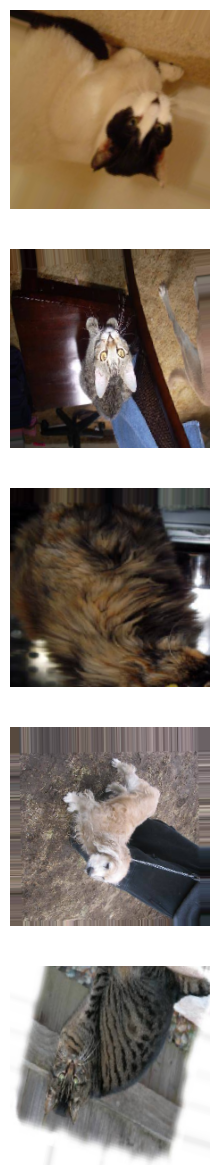

In [4]:
# function to plot images
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip( images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip( images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

In [5]:
base_model = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 4s 0us/step


In [6]:
# training only the weights associated with the output layer
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    verbose=2,
                    shuffle=True)

Epoch 1/10
63/63 - 61s - loss: 0.5883 - accuracy: 0.6910 - val_loss: 0.3926 - val_accuracy: 0.8850 - 61s/epoch - 972ms/step
Epoch 2/10
63/63 - 33s - loss: 0.4001 - accuracy: 0.8590 - val_loss: 0.2545 - val_accuracy: 0.9570 - 33s/epoch - 517ms/step
Epoch 3/10
63/63 - 39s - loss: 0.3281 - accuracy: 0.8855 - val_loss: 0.1946 - val_accuracy: 0.9680 - 39s/epoch - 613ms/step
Epoch 4/10
63/63 - 41s - loss: 0.2812 - accuracy: 0.9020 - val_loss: 0.1558 - val_accuracy: 0.9730 - 41s/epoch - 648ms/step
Epoch 5/10
63/63 - 39s - loss: 0.2625 - accuracy: 0.9035 - val_loss: 0.1302 - val_accuracy: 0.9770 - 39s/epoch - 621ms/step
Epoch 6/10
63/63 - 32s - loss: 0.2448 - accuracy: 0.9075 - val_loss: 0.1162 - val_accuracy: 0.9780 - 32s/epoch - 511ms/step
Epoch 7/10
63/63 - 32s - loss: 0.2313 - accuracy: 0.9115 - val_loss: 0.1115 - val_accuracy: 0.9790 - 32s/epoch - 503ms/step
Epoch 8/10
63/63 - 32s - loss: 0.2127 - accuracy: 0.9195 - val_loss: 0.0940 - val_accuracy: 0.9820 - 32s/epoch - 515ms/step
Epoch 9/

In [7]:
base_model.trainable = True

# The InceptionV3 model has 311 layers in total
fine_tune_limit = 260

# Fine tuning approximately the last 50 layers
for layer in base_model.layers[:fine_tune_limit]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
checkpoint_callback = ModelCheckpoint(filepath='best_model_weights.h5',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=True)

fine_tune_history = model.fit(train_generator,
                              validation_data=val_generator,
                              epochs=20,
                              initial_epoch=10,
                              verbose=2,
                              shuffle=True,
                              callbacks=[checkpoint_callback])

Epoch 11/20
63/63 - 44s - loss: 0.1734 - accuracy: 0.9305 - val_loss: 0.0438 - val_accuracy: 0.9850 - 44s/epoch - 697ms/step
Epoch 12/20
63/63 - 32s - loss: 0.1398 - accuracy: 0.9420 - val_loss: 0.0330 - val_accuracy: 0.9890 - 32s/epoch - 513ms/step
Epoch 13/20
63/63 - 35s - loss: 0.1376 - accuracy: 0.9455 - val_loss: 0.0318 - val_accuracy: 0.9910 - 35s/epoch - 559ms/step
Epoch 14/20
63/63 - 32s - loss: 0.1350 - accuracy: 0.9410 - val_loss: 0.0329 - val_accuracy: 0.9910 - 32s/epoch - 513ms/step
Epoch 15/20
63/63 - 34s - loss: 0.1004 - accuracy: 0.9660 - val_loss: 0.0334 - val_accuracy: 0.9920 - 34s/epoch - 532ms/step
Epoch 16/20
63/63 - 33s - loss: 0.0930 - accuracy: 0.9630 - val_loss: 0.0277 - val_accuracy: 0.9920 - 33s/epoch - 524ms/step
Epoch 17/20
63/63 - 33s - loss: 0.0933 - accuracy: 0.9635 - val_loss: 0.0265 - val_accuracy: 0.9930 - 33s/epoch - 524ms/step
Epoch 18/20
63/63 - 32s - loss: 0.0930 - accuracy: 0.9620 - val_loss: 0.0263 - val_accuracy: 0.9930 - 32s/epoch - 501ms/step


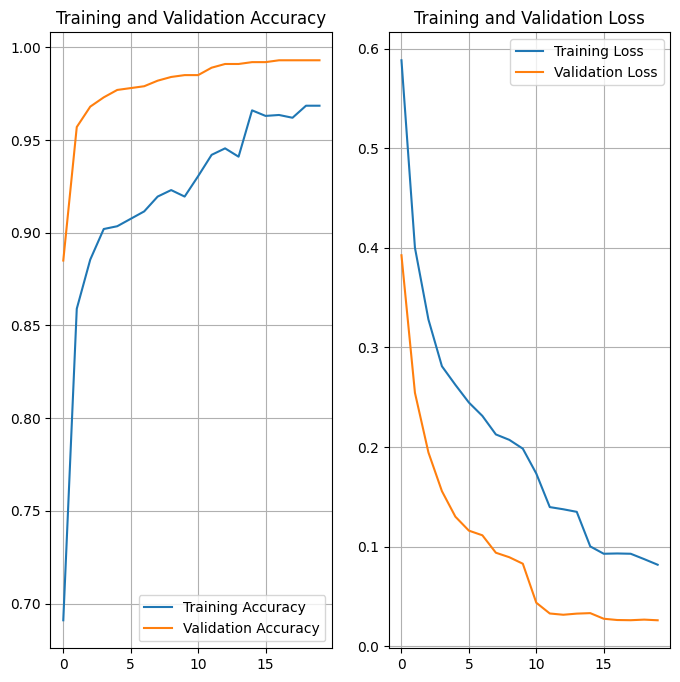

In [9]:
# plotting accuracy and loss across epochs

acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [10]:
model.load_weights('best_model_weights.h5')

probabilities = model.predict(test_generator) # can't use model.evaluate() because the test set images weren't labelled
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

2/2 [==============================] - 3s 1s/step
Your model correctly identified 98.0% of the images of cats and dogs.
